# 04. PyTorch Custom Datasets Video Notebook

We have used some datasets with PyTorch before.

But how do you get your own data into PyTorch?

One of the ways to do so is via: custom dataserts.

## Domain Libraries

Depending on what you are  working on, vision, text, audio, recommendation, you will want to look into each of the PyTorch domain libraries for existing data loading functions and customizable data loading functions

## 0. Importing PyTorch and setting up device-agnostic code

In [1]:
import torch
from torch import nn

In [ ]:
# Setup device agnosting code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

## 1. Get data

Our dataset is a subset of the Food101 dataset

Food101 starts with 101 different classes of food and 1000 images per class (750 training, 250 testing).

Our dataset starts with 3 classes of food and only 10% of the images (~75 training, 25 testing)

When starting out ML projects, it is important to try things on a small scale and then increase the scale when necessary.

The whole point is to speed up how fast you can experiment

In [ ]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
    print(f"{image_path} directory already exists... skipping download")
else:
    print(f"{image_path} does not exist, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

# Download pizza, steak and sushi datas
with open(data_path/ "pizza_steak_sushi.zip", "wb") as f:
    requests = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading pizza, steak, sushi data...")
    f.write(requests.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping pizza, steak and sushi data...")
    zip_ref.extractall(image_path)

In [ ]:
image_path

## 2. Becoming one with the data (data preparation and data exploration)

In [5]:
import os
def walk_through_dir(dir_path):
    """ Walks through dir_path returning its contents."""
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and  {len(filenames)} images in '{dirpath}'.")

In [ ]:
walk_through_dir(image_path)

In [ ]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

### 2.1 Visualizing the image

Let's write some code to:
1. Get all of the image paths
2. Pick a random image path using python's random.choice()
3. Get the image class name using `pathlib.Path.parent.stem`
4. Since we are working with images, let's open the image with python library PIL
5. We will then show the image and print metadata


In [ ]:
import random
from PIL import Image

# Set seed
# random.seed(42)

# 1. Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)
print(random_image_path)

#3. Get image class from path name (image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem
print(image_class)

# Open image with PIL
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape}->[height, width, color_channels] | (HWC)")
plt.axis(False);

## 3. Transforming data

Before we can use our image data with pytorch:
1. Turn your target data into tensors
2. Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`, we will call these Dataset or Dataloader

In [10]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transforming data with `torchvision.transforms`

In [11]:
# Write a transform for image
data_transform = transforms.Compose([
    # Resize our images to 64x64
    transforms.Resize(size=(244,244)),
    # Flip the images randomly horizontally
    transforms.RandomHorizontalFlip(p=0.5),
    #Turn the image into torch tensor
    transforms.ToTensor()
])

In [ ]:
data_transform(img)

In [ ]:
def plot_transformed_images(image_paths, transform, n=3, seed=None):
    """ Selects random images from a path of images and loads/transforms them then plots the original vs the transformed version. """

    if seed:
        random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(nrows=1,ncols=2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original\nSize:{f.size}")
            ax[0].axis(False)

            #  Transform and plot target image
            transformed_image = transform(f).permute(1, 2, 0) # (C,H,W)->(H,W,C)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed\nShape:{transformed_image.shape}")
            ax[1].axis(False)

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths=image_path_list, transform=data_transform, n=3, seed=None)

## 4. Option 1: Loading image data using ImageFolder

We can load image classification data using `torchvision.datasets.ImageFolder`

In [ ]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform, # a transform for the data
                                  target_transform=None) # a transform for the label/target

test_data = datasets.ImageFolder(root=test_dir, transform=data_transform)
train_data, test_data

In [ ]:
# Get class names as list
class_names = train_data.classes
class_names

In [ ]:
# Get class name as dict
class_dict = train_data.class_to_idx
class_dict

In [ ]:
# Check the lengths of our dataset
len(train_data), len(test_data)

In [ ]:
train_data.samples[0]

In [ ]:
# Index on the train_data Dataset to get a single image and label
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n {img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label: {type(label)}")

In [ ]:
# Rearrange the order of dimesions
img_permute = img.permute(1,2,0)

# Print out differnet shapes
print(f"Original shape: {img.shape}-> [C, H, W]")
print(f"Image permut: {img_permute.shape}-> [H,W,C]")

# Plot the image
plt.figure(figsize=(10,7))
plt.imshow(img_permute)
plt.axis("off")
plt.title(class_names[label], fontsize=14)

### 4.1 Turn loaded images into `DataLoader`

In [ ]:
# Turn train and test datasets into Dataloader's
from torch.utils.data import DataLoader

# Setup the batch size hyperparameter
BATCH_SIZE=32

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
test_dataloader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

train_dataloader, train_dataloader

In [ ]:
# Let's checkout what we have created
print(f"DataLoaders: {train_dataloader, test_dataloader}")
print(f"Length of train dataloade:{len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloade:{len(test_dataloader)} batches of {BATCH_SIZE}")

In [ ]:
img, label = next(iter(train_dataloader))

# Batch size will now be 32, you cam change the batch size if you like
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Image shape: {label.shape}")

## 5. Option 2: Loading Image Data with a custom `Dataset`
1. Want tot be able to load images from file
2. Want to be able to class names from the Dataset
3. Want to be able to get classes as dictionary from the Dataset


Pros: 
* Can create a `Dataset` out of almost anything
* Not limited to PyTorch pre-built `Dataset` functions

Cons:
* Even though you could create dataset out of almost anything, it does not mean it will work
* Using a custom dataset oftem results in us writing more code, which could be prone to errors to performance issues

All custom datasets in pytorch, often subclass

In [24]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [ ]:
# Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

### 5.1 Creating a helper function to get class names

We want a function to:
1. Get the class names using `os.scandir()` to traverse a target directory(ideally the directory is in standard image classification format)
2. Raise an error if the class names are not found
3. Turn the class names into a dict and a lsit and return them.

In [ ]:
# Setup path for target directory
target_directory = train_dir
print(f"Target dir: {target_directory}")

# Get the class names for mthe target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

In [ ]:
list(os.scandir(target_directory))

In [28]:
def find_classes(directory:str) -> Tuple[List[str], Dict[str,int]]:
    """ Find the class folder names in a target directory. """
    # 1. Get the class names by scanning the target directory
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

    # 2. Raise an error if class names could not be found
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}... pleaes check file structure")

    # 3. Create a dictionary of index labels (computers prefer numbers rather than strings as labels)
    class_to_idx = {class_name:i for i, class_name in enumerate(class_names)}
    return classes, class_to_idx

In [ ]:
find_classes(target_directory)

### 5.2 Create a custom `Dataset`to replicate `ImageFolder`

To create our own custom dataset, we want to:

1. Subclass `torch.utils.data.Dataset`
2. Init our subclass with target directory as well as a transform if we would like to transform our data.
3. Create several attributes:
    * paths - pathjs of our images
    * transform - the transform we would like to use
    * classes - a list of the target classes
    * class_to_idx - a dict of the target classes mapped to integer labels
4. Create a function to `load_images()`, this function will open an image
5. Overwrite the `__len__()` method to return the length of our dataset
6. Overwrite the `__getitem__()` method to return a giver sample when passed an index

In [30]:
#0. Write a custom dataset class
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
    # 2. Initialize our custom dataset
    def __init__(self, targ_dir:str, transform=None):
        #3. Create class attributes
        # Get all of the image paths
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
        # Setup transforms
        self.transform = transform
        # Create classess and class_to_idx_attributes
        self.classes, self.class_to_idx = find_classes(targ_dir)

    # 4. Create a function to laod images
    def load_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.paths[index]
        return Image.open(image_path)

    # 5. Overwrite __len__()
    def __len__(self) -> int:
        "Returns the total number of samples"
        return len(self.paths)

    # 6. Overwrite __getitem__() to return a particular sample
    def __getitem__(self, index: int) -> Tuple[torch.tensor, int]:
        "Returns one sample of data, data and label (X, y)."
        img = self.load_image(index)
        class_name = self.paths[index].parent.name # excepts path in format: data_folder/class_name/image.jpg
        class_idx = self.class_to_idx[class_name]

        # Transform if necessary
        if self.transform:
            return self.transform(img), class_idx # return data, label (X,y)
        else:
            return img, class_idx # return untransformed image and label

In [31]:
# Create a transform
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize(size=(244,244)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(244,244)),
    transforms.ToTensor()
])

In [32]:
# Test out ImageFolderCustom
train_data_custom = ImageFolderCustom(targ_dir=train_dir, transform=train_transforms)

test_data_custom = ImageFolderCustom(targ_dir=test_dir, transform=test_transforms)

In [ ]:
# Check for equality between original ImageFolder Dataset and ImageFolderCustomDataset
print(train_data_custom.classes==train_data.classes)
print(train_data_custom.classes==train_data.classes)

### 5.3 Create a function to show random images

1. Take in a `Datset` and a number of other parameters such as class names and how many iamges to visualize
2. To prevent the display getting out of hand, lets cap the numebr of images to see at 10.
3. Set the random seed for reproducibility
4. Get a list of random sample indexes from the target dataset.
5. Setup a matplotlib plot.
6. Loop through the random sample indexes and plot them with matpotlib
7. Make sure the dimensions of our images line up with matplotlip (HWC)

In [34]:
# 1. Create a function to take in a dataset
def display_random_images(dataset: torch.utils.data.Dataset, classes:List[str] = None, n: int =10, display_shape: bool = True, seed: int =None):
    # 2. Adjust display if n is too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display, purposes, n should not be larger than 10, setting to 10 and removing shape display.")

    # 3. Set the seed
    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_samples_idx = random.sample(range(len(train_data_custom)), k=n)

    # 5. Setup pot
    plt.figure(figsize=(16,8))

    # 6. Loop through random indexes and plot them with matplotlib
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7. Adjust tensor dimensions from plotting
        targ_image_adjust = targ_image.permute(1,2,0) # (CHW) -> (HWC)

        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"Class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)



In [ ]:
# Display random images from the ImageFolder created dataset
display_random_images(train_data, n=5, classes=class_names, seed=None)


In [ ]:
# Display random images from the ImageFloderCustom Dataset
display_random_images(train_data_custom, n=5, classes=class_names, seed=42)

### 5.4 Turn custom loaded images into `DataLoader`

In [ ]:
# Turn train and test datasets into Dataloader's
from torch.utils.data import DataLoader

# Setup the batch size hyperparameter
BATCH_SIZE=32
NO_OF_WORKKERS=0

# Turn datasets into iterables (batches)
train_dataloader_custom = DataLoader(dataset=train_data_custom, batch_size=BATCH_SIZE, shuffle=True ,num_workers=NO_OF_WORKKERS)
test_dataloader_custom = DataLoader(dataset=test_data_custom, batch_size=BATCH_SIZE, shuffle=False, num_workers=NO_OF_WORKKERS)

train_dataloader_custom, test_dataloader_custom

In [ ]:
# Get image and labnel from custom dataloader
img_custom, label_custom = next(iter(train_dataloader_custom))

# Print out the shapes
img_custom.shape, label_custom.shape


## 6. Other forms of transforms (data augmentation)

Data augmentation is the process of artificially adding diversity to your training data.

In the case of image data, this may mean applying various image transformation to the training images

This practice hopefully results in a model that is more generaizable to unseen data

Let's take a look at one particular tyhpe of data augmentation used to train pytorch vision models to state of the art levels

https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/

In [39]:
# Let us look at trivialaugment - https://pytorch.org/vision/main/auto_examples/transforms/plot_transforms_illustrations.html#trivialaugmentwide
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor()
])

In [ ]:
# Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list[:10]

In [ ]:
# Plot random transformed images
plot_transformed_images(image_paths=image_path_list, transform=train_transform, n=3, seed=None)

## 7. Model 0: TinyVGG without data augmentation (CNN Explainer)

### 7.1 Creating transforms and loading data for model 0

In [143]:
# Create a simple transform
simple_transform = transforms.Compose([
    transforms.Resize(size=(244,244)),
    transforms.ToTensor()
])

In [144]:
# 1. Load and transform data
from torchvision import datasets
train_data_simple = datasets.ImageFolder(root=train_dir, transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir, transform=simple_transform)

# 2. Turn datasets in to DataLoders
import os
from torch.utils.data import DataLoader

# Setup batch size and number of works
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

# Create Dataloader
train_dataloader_simple= DataLoader(dataset=train_data_simple, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
test_dataloader_simple= DataLoader(dataset=test_data_simple, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)


### 7.2 Create TinyVGG model class

In [1]:
class TinyVGG(nn.Module):
    """ Model architecture copying TinyVGG from CNN Explainer"""
    def __init__(self, input_shape:int, hidden_units: int, output_shape:int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3,padding=1,stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3,padding=1,stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )


        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3,padding=1,stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3,padding=1,stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3,padding=1,stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3,padding=1,stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units * 30 * 30, out_features=output_shape)
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        # print(x.shape)
        x = self.conv_block_3(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x
        # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # benefits from operator fusion

NameError: name 'nn' is not defined

In [173]:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, hidden_units=10,output_shape=len(class_names)).to(device)
# model_0

### 7.3 Try a forward pass on a single image (to test the model)

In [147]:
# Get a single image batch
image_batch, label_batch = next(iter(train_dataloader_simple))
# image_batch, label_batch

In [ ]:
model_0(image_batch.to(device))

### 7.4 Use `torchinfo` to get an idea of the shapes going through our model

In [ ]:
from torchinfo import summary

summary(model=model_0, input_size=(1, 3, 244,244))

### 7.5 Create train and test loops functions

* `train_step()` - takes in a model and dataloader and trains the model on the dataloader.
* `test_step()` - takes in a model and dataloader and evaluates the model on the dataloader.

In [154]:
# Create train_step()
import torch.utils


def train_step(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader, loss_fn: torch.nn.Module, optimizer: torch.optim.Optimizer, device=device):
    # Put the model in train mode
    model.train()

    # Setup  train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to the target device
        X, y = X.to(device), y.to(device)

        # Forward pass
        y_pred = model(X) # output model logits

        # Calculate the loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # Optimizer zero grad
        optimizer.zero_grad()

        # Loss backward
        loss.backward()

        # Optimizer.step
        optimizer.step()

        # Calculate accuracy metric
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += ((y_pred_class == y).sum().item()/len(y_pred))


    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)

    return train_loss, train_acc


In [155]:
# Create a test step
def test_step(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader, loss_fn: torch.nn.Module, device=device):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on infrence mode
    with torch.inference_mode():
        # Loop through Dataloader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to the target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate the loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate the accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc


### 7.6 Create a `train()` function to combine `train_step()` and `test_step()`

In [156]:
from timeit import default_timer as timer
from tqdm.auto import tqdm

# Create a train function that takes in various parameters
def train(model:torch.nn.Module,
          train_dataloader:torch.utils.data.DataLoader,
          test_dataloader:torch.utils.data.DataLoader,
          optimizer:torch.optim.Optimizer,
          loss_fn:torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int=5,
          device=device):
    # Create empty result dict
    results = {"train_loss": [], "train_acc": [], "test_loss":[], "test_acc":[]}


    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc =  train_step(model=model, dataloader=train_dataloader,loss_fn=loss_fn, optimizer=optimizer,device=device)
        test_loss, test_acc = test_step(model=model, dataloader=test_dataloader, loss_fn=loss_fn, device=device)

        # Print out
        print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc:{test_acc:.4f}")

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # Return the filled results at the end of the epochs
    return results


### 7.7 Train and evaluate model 0

In [ ]:
# Set random seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 10

# Recreate an instance of TinyVGG
model_0 = TinyVGG(
    input_shape=3,  # number of color channel
    hidden_units=30,
    output_shape=len(train_data.classes)
).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr =0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_results =  train(model=model_0,
                         train_dataloader=train_dataloader_simple,
                         test_dataloader=test_dataloader_simple,
                         optimizer=optimizer,
                         loss_fn=loss_fn,
                         epochs=NUM_EPOCHS,
                         device="cuda")

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

In [ ]:
# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_results =  train(model=model_0,
                         train_dataloader=train_dataloader_simple,
                         test_dataloader=test_dataloader_simple,
                         optimizer=optimizer,
                         loss_fn=loss_fn,
                         epochs=NUM_EPOCHS,
                         device="cuda")

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

### 7.8 Plot the loss curves of Model 0



In [ ]:
# Get the model_0_results key
model_0_results.keys()

In [160]:
def plot_loss_curves(results:Dict[str,List[float]]):
    """Plots training curves of a results dictionary."""
    # Get the loss values of the results dictionary(training and test)
    train_loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    train_accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    # Figure out how many epochs there were
    epochs = range(len(results["train_loss"]))

    # Setup a plot
    plt.figure(figsize=(15,7))

    # Plot the loss
    plt.subplot(1,2,1)
    plt.plot(epochs, train_loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot the accuracy
    plt.subplot(1,2,2)
    plt.plot(epochs, train_accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

In [ ]:
plot_loss_curves(model_0_results)

## 8. What should an ideal loss curve look like?

A loss curve is one  of the most helpful way to troubleshoot a model.

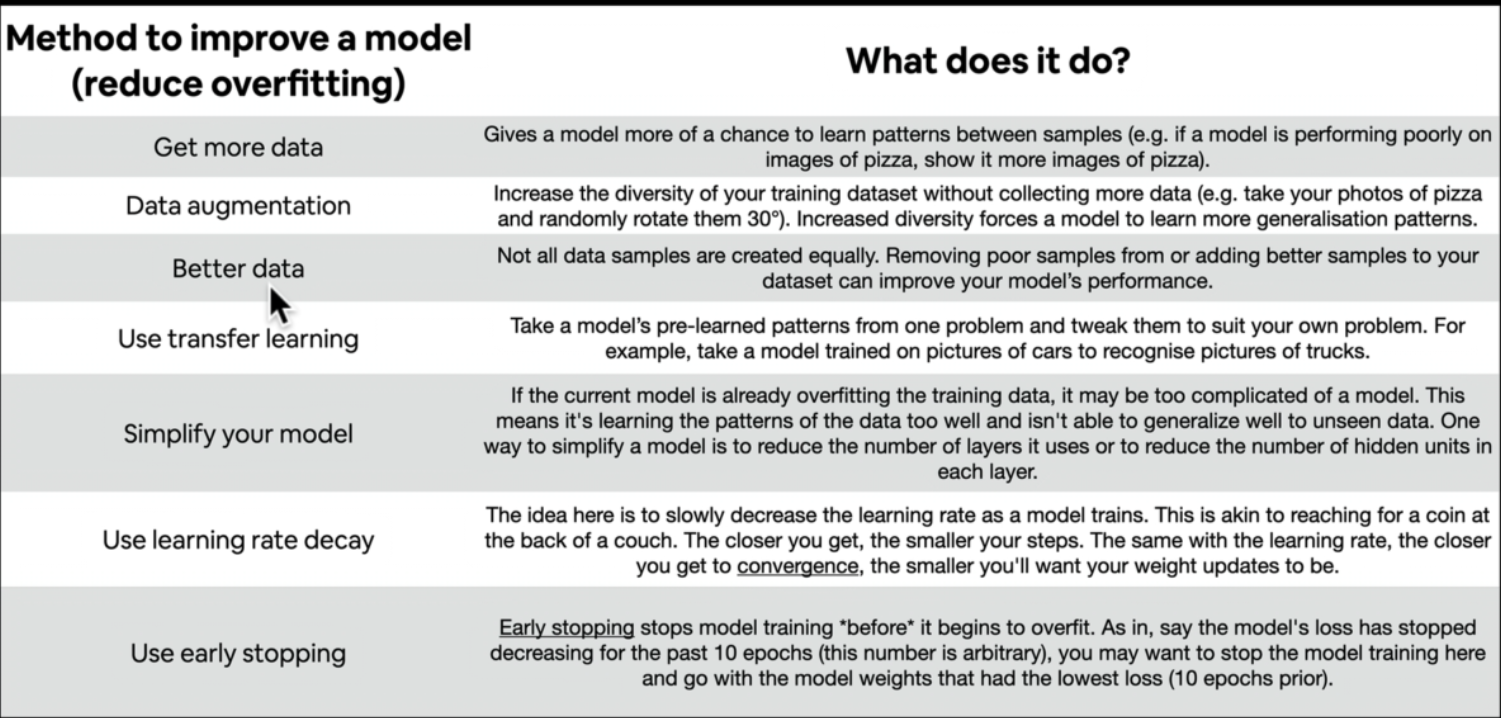

## 9. Model 1: Tiny VGG with data augmentation

Now let us try another modelling experiment this time using the same model as before with some slight data augmentation

### 9.1 Create transform with data augmentation

In [174]:
# Create training transform with TriviailAugment
from torchvision import transforms
train_transform_trivial = transforms.Compose([
    transforms.Resize(size=(244,244)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_tranform_simple = transforms.Compose([
    transforms.Resize(size=(244,244)),
    transforms.ToTensor()
])

### 9.2 Create train and test `Dataset` and `Dataloader` with data augmentaion

In [178]:
# Turn image folders into Datasets
from torchvision import datasets

train_data_augmented = datasets.ImageFolder(root=train_dir, transform=train_transform_trivial)

test_data_simple = datasets.ImageFolder(root=test_dir ,transform= test_tranform_simple)

In [179]:

# Turn our Datasets into Dataloaders
import os
from torch.utils.data import DataLoader
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(dataset=train_data_augmented, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
test_dataloader_simple = DataLoader(dataset=test_data_simple, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

### 9.3 Construct and train model 1

This time we will be using the same model architecture except this time we have augmented the training data

In [ ]:
# Create model_1 and sent it to the target device
torch.manual_seed(42)
model_1 = TinyVGG(input_shape=3, hidden_units=30, output_shape=len(train_data_augmented.classes)).to(device)
model_1

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
NUM_EPOCHS = 10

# Setup loss function
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model 1
model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS,
                        device=device)

# End the time and print out how long it took
end_time = timer()
print(f"Total training time for model_1: {end_time - start_time:.3f} seconds")

In [ ]:
# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model 1
model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS,
                        device=device)

# End the time and print out how long it took
end_time = timer()
print(f"Total training time for model_1: {end_time - start_time:.3f} seconds")

### 9.4 Plot the loss curves of model 1

In [ ]:
plot_loss_curves(model_1_results)

## 10. Compare model results 

After evaluating our modelling experiments on theri own, It's important to compare them to each other.

There is a few different ways to do this:
1. Hard coding
2. PyTorch + Tensorboard
3. Weights & Biases 
4. MLFlow

In [ ]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)

model_0_df

In [ ]:
# Setup a plot
plt.figure(figsize=(15,10))

# Get number of epochs
epochs = range(len(model_0_df))

# Plot Train loss
plt.subplot(2,2,1)
plt.plot(epochs, model_0_df["train_loss"], label="Model 0")
plt.plot(epochs, model_1_df["train_loss"], label="Model 1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot Train Accuracy
plt.subplot(2,2,3)
plt.plot(epochs, model_0_df["train_acc"], label="Model 0")
plt.plot(epochs, model_1_df["train_acc"], label="Model 1")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend()

# Plot Test loss
plt.subplot(2,2,2)
plt.plot(epochs, model_0_df["test_loss"], label="Model 0")
plt.plot(epochs, model_1_df["test_loss"], label="Model 1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot Test Accuracy
plt.subplot(2,2,4)
plt.plot(epochs, model_0_df["test_acc"], label="Model 0")
plt.plot(epochs, model_1_df["test_acc"], label="Model 1")
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.legend()


## 11. Making a prediction on a custom image

Although we have trained a model on custom data. How do you make a prediction on a sample/image that is not in either training or testing data

In [ ]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "pizza-pizza.jpg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, 'wb') as f:
        # When downloading an image
        request = requests.get("https://media.istockphoto.com/id/1442417585/photo/person-getting-a-piece-of-cheesy-pepperoni-pizza.jpg?s=612x612&w=0&k=20&c=k60TjxKIOIxJpd4F4yLMVjsniB4W1BpEV4Mi_nb4uJU=")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exiwsts, skipping download...")

### 11.1 Loading in a custom image with PyTorch

We have to make sure our custom image is in the same format as the data our model was trained on.

* In tensor form with datatype (torch.float32)
* Of shape 64x64x3
* On the right device

In [ ]:
import torchvision

# Read in custom image
custom_image_uint8 = torchvision.io.read_image(custom_image_path)
print(f"Custom image tensor:\n {custom_image_uint8}")
print(f"custom image shape: {custom_image_uint8.shape}")
print(f"custom image datatype: {custom_image_uint8.dtype}")

In [ ]:
plt.imshow(custom_image_uint8.permute(1,2,0))

### 11.2 Making a prediction on custom image with trained PyTorch model

In [ ]:
# Try to make prediction on an iamge in uint8 format
model_1.eval()
with torch.inference_mode():
    model_1(custom_image_uint8.to(device))

In [ ]:
# Load in the custom image and convert to torch.float32
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32) / 255
custom_image

In [ ]:
plt.imshow(custom_image.permute(1,2,0))

In [ ]:
custom_image.shape

In [ ]:
model_1.eval()
with torch.inference_mode():
    model_1(custom_image.to(device))

In [ ]:
# Create transform pipeline to resize image
from torchvision import transforms
custom_image_transform = transforms.Compose([
    transforms.Resize(size=(244,244))
])

# Transform target iamge
custom_image_transformed = custom_image_transform(custom_image)

# Print out the shapes
print(f"Original shape: {custom_image.shape}")
print(f"Transformed shape: {custom_image_transformed.shape}")

In [ ]:
plt.imshow(custom_image_transformed.permute(1,2,0))

In [ ]:
# This will error image is not in same device
model_1.eval()
with torch.inference_mode():
    custom_image_pred = model_1(custom_image_transformed)

In [ ]:
# This will error no batch size
model_1.eval()
with torch.inference_mode():
    custom_image_pred = model_1(custom_image_transformed.to(device))

In [ ]:
custom_image_transformed.shape, custom_image_transformed.unsqueeze(0).shape

In [ ]:
model_1.eval()
with torch.inference_mode():
    custom_image_pred = model_1(custom_image_transformed.unsqueeze(0).to(device))

custom_image_pred

Note, to make predicition on a custom image we had to:

* Load the image and turn it into a tensor
* Make sure the image was the same datatype as the model (torch.float32)
* Make sure the image the same shape as the data the model was trained on (3, 64, 64) with a batch size.. (1,3,64,64)
* Make sure the image was on the same device as our model

In [ ]:
# Convert logits -> prediction probabilities
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
custom_image_pred_probs

In [ ]:
# Convert prediction probabilities -> prediction labels
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1).cpu()
custom_image_pred_label

In [ ]:
class_names[custom_image_pred_label]

### 11.3 Putting custom image prediction together: Building a function

Ideal outcome:

A function where we pass an image path to and have our model predict on that image + prediction

In [128]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str] = None,
                        transform=None,
                        device=device
                        ):
    """Makes a prediction on a target image with a trained model and plots the iamge and prediction"""
    # Load in the image
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

    # Divide the iamge pixel values by 255 to get them between [0,1]
    target_image =target_image/255.

    # Transform if necessary
    if transform:
        target_image = transform(target_image)

    # Make sure the model is on the target device
    model.to(device)

    # Turn on eval/infrence model and make a prediction
    model.eval()
    with torch.inference_mode():
        # Add an extra dimension to the image (This is the batch dimension)
        target_image = target_image.unsqueeze(0)

        # Make a prediction on the image with extra dimension
        target_image_pred = model(target_image.to(device)) # make sure the target image is on the right device

    # Convert logits -> prediction probabilities
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # Plot the image alongside the prediction and prediction probability
    plt.imshow(target_image.squeeze().permute(1,2,0)) # remove batch dimension and rearrange shape to be HWC

    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else:
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"

    plt.title(title)
    plt.axis("off")

In [ ]:
# Pred on our custom image
pred_and_plot_image(model=model_0, image_path='data/istockphoto.jpg', class_names=class_names, transform=custom_image_transform, device=device)